# Dataset Source

## [Kaggle dataset source](https://www.kaggle.com/dgawlik/nyse)

# Import Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip install fbprophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

In [370]:
import math

In [373]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [181]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Read the file, cleaning data

In [5]:
df = pd.read_csv('prices-split-adjusted.csv')

In [6]:
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


<AxesSubplot:>

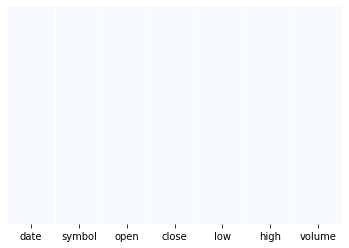

In [7]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [8]:
df.shape

(851264, 7)

## For the sake of brevity, only 5 companies will be analysed for EDA: 
- Google(GOOGL)
- Amazon (AMZN)
- Apple (AAPL)
- Microsoft (MSFT)
- McDonalds (MCD)

In [9]:
new_df=df[(df['symbol']=='GOOGL') | (df['symbol']=='AMZN') | (df['symbol']=='AAPL') | (df['symbol']=='MSFT') | (df['symbol']=='MCD')]

In [10]:
new_df.head()

,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
284,2010-01-04,AMZN,136.250000,133.899994,133.139999,136.610001,7599900.0
440,2010-01-04,GOOGL,313.788792,313.688694,312.432438,315.070073,3908400.0
525,2010-01-04,MCD,62.630001,62.779999,62.310001,63.070000,5839300.0
544,2010-01-04,MSFT,30.620001,30.950001,30.590000,31.100000,38409100.0


In [11]:
new_df.set_index('date',inplace=True)

# EDA

In [12]:
companies=new_df['symbol'].unique().tolist()

In [13]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8810 entries, 2010-01-04 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  8810 non-null   object 
 1   open    8810 non-null   float64
 2   close   8810 non-null   float64
 3   low     8810 non-null   float64
 4   high    8810 non-null   float64
 5   volume  8810 non-null   float64
dtypes: float64(5), object(1)
memory usage: 481.8+ KB


In [14]:
new_df[new_df['symbol']=='GOOGL']['close'].max()

835.73999

##### Finding the max Close price for each companies' stock during the period of observation

In [15]:
close_dict = {}
for company in companies:
    close_dict[company]=new_df[new_df['symbol']==company]['close'].max()
close_dict 

{'AAPL': 133.0,
 'AMZN': 844.3599849999999,
 'GOOGL': 835.73999,
 'MCD': 131.600006,
 'MSFT': 63.619999}

###### Checking the return of each company 

$$ RETURN_t = \frac{p_t}{p_{t-1}} - 1 $$

In [16]:
returns = pd.DataFrame()

In [17]:
for company in companies:
    returns[company+' Return'] = new_df[new_df['symbol']==company]['close'].pct_change()
returns.head()

,AAPL Return,AMZN Return,GOOGL Return,MCD Return,MSFT Return
date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,0.005900,-0.004404,-0.007646,0.000323
2010-01-06,-0.015906,-0.018116,-0.025209,-0.013644,-0.006137
2010-01-07,-0.001849,-0.017013,-0.023280,0.007323,-0.010400
2010-01-08,0.006648,0.027077,0.013331,-0.000969,0.006897


In [18]:
returns.tail()

,AAPL Return,AMZN Return,GOOGL Return,MCD Return,MSFT Return
date,,,,,
2016-12-23,0.001978,-0.007503,-0.002322,-0.004688,-0.004878
2016-12-27,0.006351,0.014213,0.002637,-0.000568,0.000632
2016-12-28,-0.004264,0.000946,-0.006618,-0.003169,-0.004583
2016-12-29,-0.000257,-0.009040,-0.002101,0.000897,-0.001429
2016-12-30,-0.007796,-0.019970,-0.012991,-0.008714,-0.012083


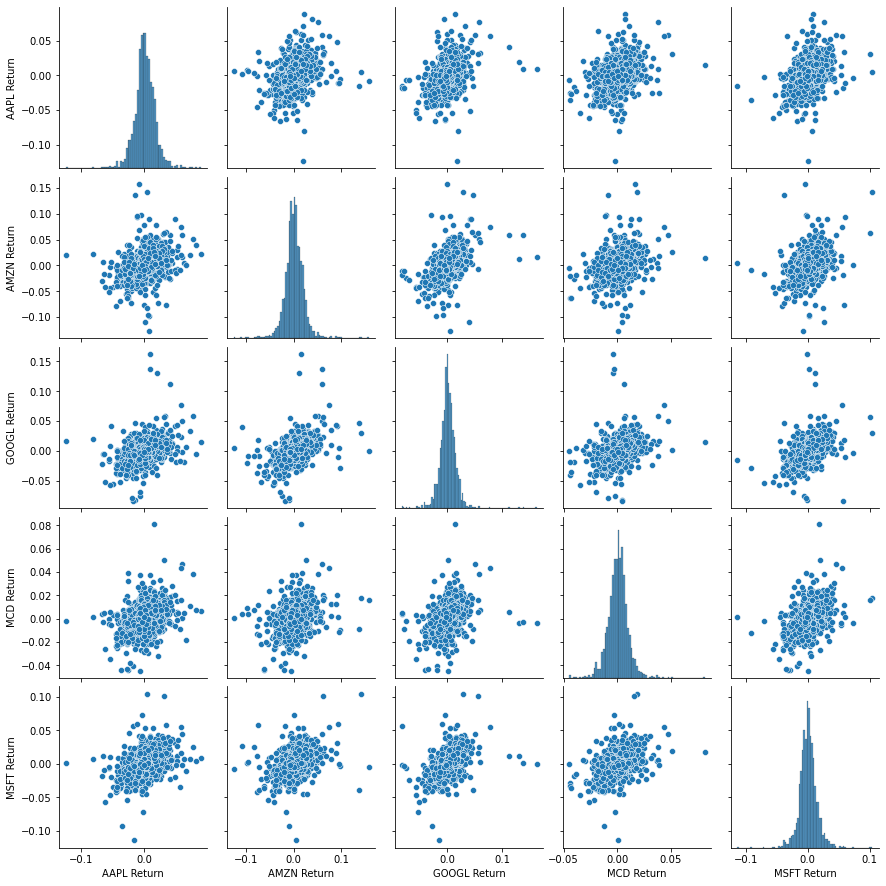

In [19]:
sns.pairplot(returns[1:])

##### Check the max and the min return dates

In [20]:
returns.idxmin()

AAPL Return     2013-01-24
AMZN Return     2011-10-26
GOOGL Return    2012-01-20
MCD Return      2016-07-26
MSFT Return     2013-07-19
dtype: object

In [21]:
returns.idxmax()

AAPL Return     2012-04-25
AMZN Return     2012-04-27
GOOGL Return    2015-07-17
MCD Return      2015-10-22
MSFT Return     2015-04-24
dtype: object

In [22]:
returns.std() # MCD is the saffest and AMZN the rikiest 

AAPL Return     0.016518
AMZN Return     0.020395
GOOGL Return    0.015685
MCD Return      0.009605
MSFT Return     0.014607
dtype: float64

In [23]:
# deviations per year

In [24]:
years = ['2010','2011','2012','2013','2014','2015','2016']

In [25]:
'2010'+'-01-01'

'2010-01-01'

In [26]:
deviations=pd.DataFrame()

In [27]:
for year in years:
    deviations[year] = returns[year+'-01-01':year+'-12-31'].std()
deviations

,2010,2011,2012,2013,2014,2015,2016
AAPL Return,0.016868,0.016539,0.018604,0.017986,0.013657,0.016841,0.014722
AMZN Return,0.020611,0.024192,0.020038,0.017021,0.020297,0.021147,0.018711
GOOGL Return,0.017580,0.018577,0.014428,0.013806,0.013407,0.018178,0.012675
MCD Return,0.009599,0.010619,0.008861,0.007678,0.007981,0.012135,0.009612
MSFT Return,0.013820,0.014775,0.013235,0.015719,0.011964,0.017801,0.014294


##### Returns for each company per year 

In [28]:
years

['2010', '2011', '2012', '2013', '2014', '2015', '2016']

In [29]:
range(len(years))

range(0, 7)

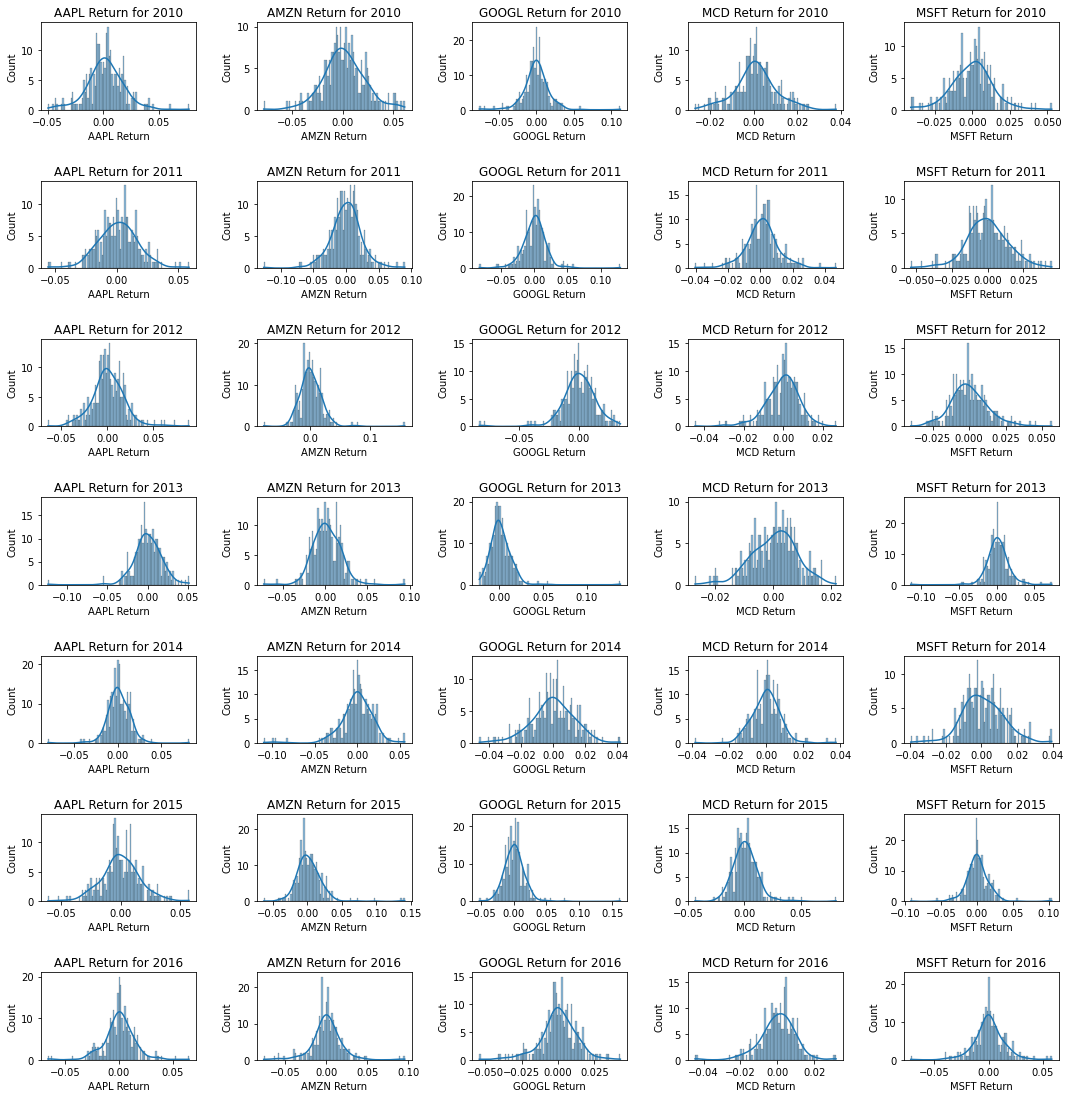

In [30]:
fig, axes = plt.subplots(7,5, figsize=(15,15))
fig.tight_layout(h_pad=5, w_pad=2)

for i in range(len(years)):
    for j in range(len(companies)):
        sns.histplot(returns[years[i]+'-01-01':years[i]+'-12-31'][companies[j]+' Return'],
                     bins=100, 
                     kde=True,ax=axes[i,j]).set_title(f'{companies[j]} Return for {years[i]}')
    #plt.title(f'{companies[j]} Return for {years[i]}')
plt.show()

##### Close price for each company over period analysis

F:\Ana3\envs\tensorflow_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


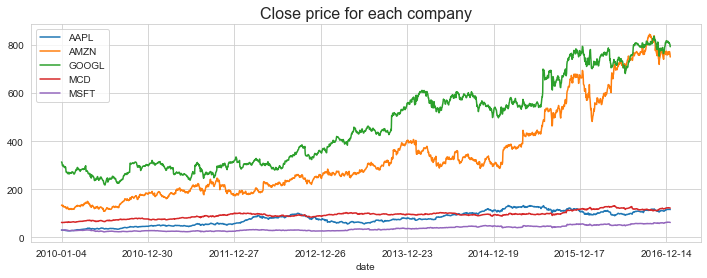

In [31]:
sns.set_style('whitegrid')
for company in companies:
    new_df[new_df['symbol']==company]['close'].plot(figsize=(12,4), label=company)
plt.legend()
plt.title('Close price for each company',fontsize=16)
plt.show()

F:\Ana3\envs\tensorflow_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


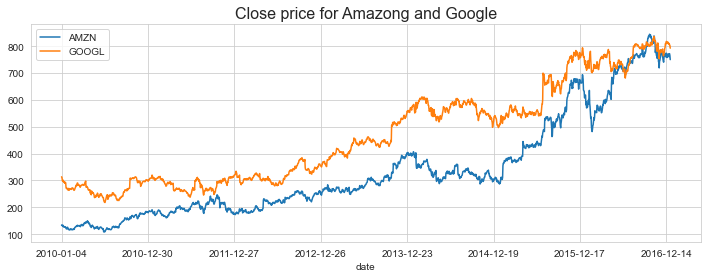

In [32]:
new_df[new_df['symbol']=='AMZN']['close'].plot(figsize=(12,4),label='AMZN')
new_df[new_df['symbol']=='GOOGL']['close'].plot(figsize=(12,4), label='GOOGL')
plt.title('Close price for Amazong and Google',fontsize=16)
plt.legend()
plt.show()

F:\Ana3\envs\tensorflow_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


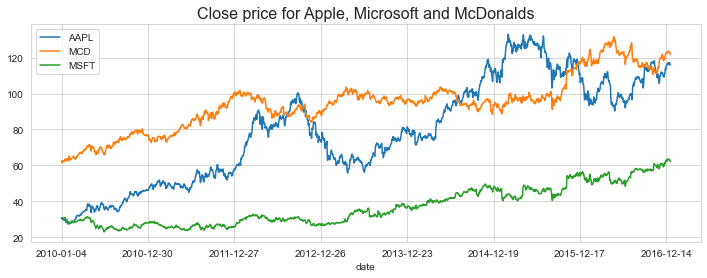

In [33]:
new_df[new_df['symbol']=='AAPL']['close'].plot(figsize=(12,4), label='AAPL')
new_df[new_df['symbol']=='MCD']['close'].plot(figsize=(12,4), label='MCD')
new_df[new_df['symbol']=='MSFT']['close'].plot(figsize=(12,4), label='MSFT')
plt.title('Close price for Apple, Microsoft and McDonalds',fontsize=16)
plt.legend()
plt.show()

##### Volume of shares traded for each company over period analysis

F:\Ana3\envs\tensorflow_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


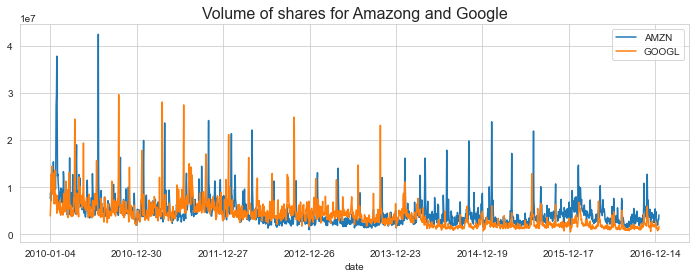

In [34]:
new_df[new_df['symbol']=='AMZN']['volume'].plot(figsize=(12,4),label='AMZN')
new_df[new_df['symbol']=='GOOGL']['volume'].plot(figsize=(12,4), label='GOOGL')
plt.title('Volume of shares for Amazong and Google',fontsize=16)
plt.legend()
plt.show()

F:\Ana3\envs\tensorflow_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


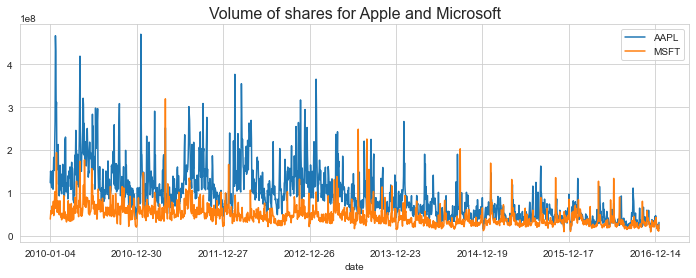

In [35]:
new_df[new_df['symbol']=='AAPL']['volume'].plot(figsize=(12,4), label='AAPL')
new_df[new_df['symbol']=='MSFT']['volume'].plot(figsize=(12,4), label='MSFT')
plt.title('Volume of shares for Apple and Microsoft',fontsize=16)
plt.legend()
plt.show()

F:\Ana3\envs\tensorflow_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


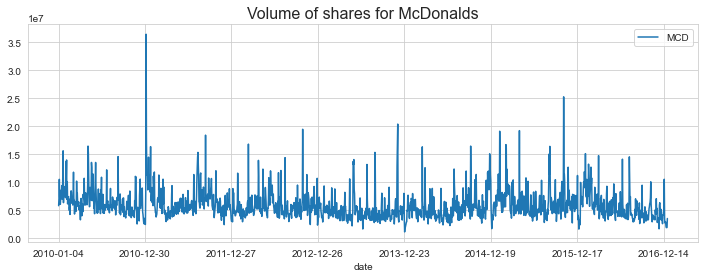

In [36]:
new_df[new_df['symbol']=='MCD']['volume'].plot(figsize=(12,4), label='MCD')
plt.title('Volume of shares for McDonalds',fontsize=16)
plt.legend()
plt.show()

##### Moving Averages

F:\Ana3\envs\tensorflow_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


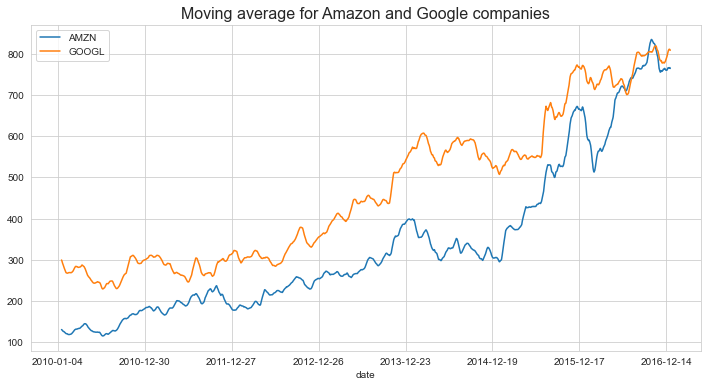

In [37]:
plt.figure(figsize=(12,6))
plt.title('Moving average for Amazon and Google companies', fontsize=16)
new_df[new_df['symbol']=='AMZN']['close'].rolling(window=12).mean().plot(label='AMZN')
new_df[new_df['symbol']=='GOOGL']['close'].rolling(window=12).mean().plot(label='GOOGL')
plt.legend()
plt.show()

F:\Ana3\envs\tensorflow_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


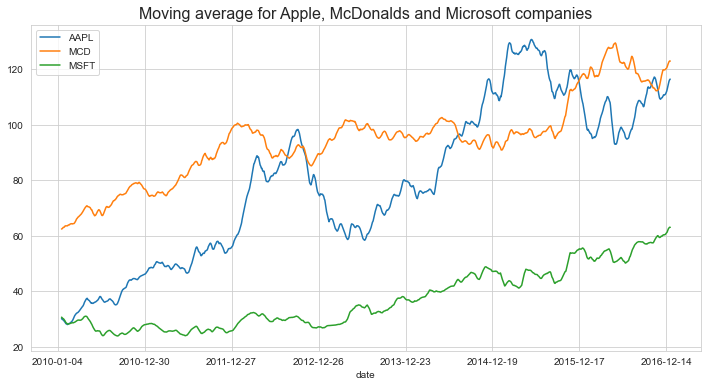

In [38]:
plt.figure(figsize=(12,6))
plt.title('Moving average for Apple, McDonalds and Microsoft companies', fontsize=16)
new_df[new_df['symbol']=='AAPL']['close'].rolling(window=12).mean().plot(label='AAPL')
new_df[new_df['symbol']=='MCD']['close'].rolling(window=12).mean().plot(label='MCD')
new_df[new_df['symbol']=='MSFT']['close'].rolling(window=12).mean().plot(label='MSFT')
plt.legend()
plt.show()

In [39]:
close_df=pd.DataFrame()

In [40]:
for company in companies:
    close_df[company] = new_df[new_df['symbol']==company]['close'].values
close_df.head()

,AAPL,AMZN,GOOGL,MCD,MSFT
0,30.572857,133.899994,313.688694,62.779999,30.950001
1,30.625713,134.690002,312.307316,62.299999,30.959999
2,30.138571,132.250000,304.434452,61.450001,30.770000
3,30.082857,130.000000,297.347355,61.900002,30.450001
4,30.282858,133.520004,301.311314,61.840000,30.660000


In [41]:
mask = np.zeros_like(close_df.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

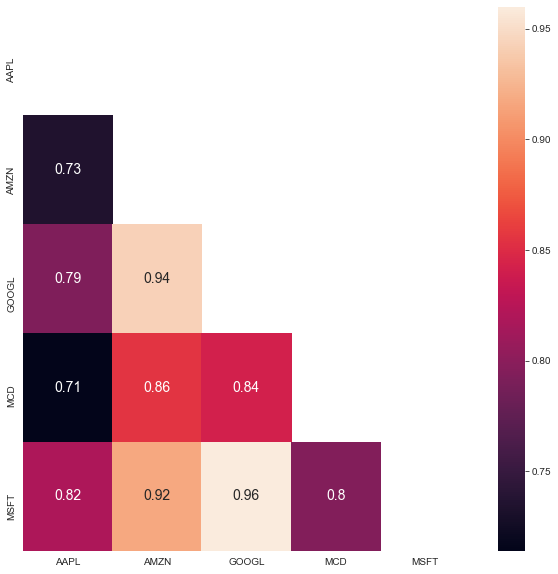

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(close_df.corr(),mask=mask, annot=True, annot_kws={'size':14})
plt.show()

# Forecast analysis

## 1. Facebook prophet Analysis

##### Lets check one company: e.g. Amazon

In [511]:
def prophet(company, periods):
    company_stock = new_df[new_df['symbol']==company]['close']
    close_comp=pd.DataFrame()
    # change the headers to ds and y for prophet
    close_comp['ds'] = company_stock.index
    close_comp['y'] = company_stock.values
    
    # prophet analysis
    model = Prophet(interval_width=0.95)
    model.fit(close_comp)
    
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    figure   = model.plot(forecast, xlabel='Date', ylabel='close')
    figure2  = model.plot_components(forecast)
    return figure , figure2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(<Figure size 720x432 with 1 Axes>, <Figure size 648x648 with 3 Axes>)

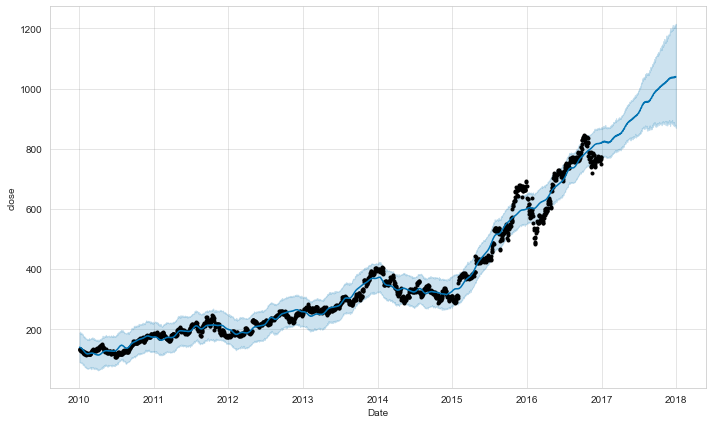

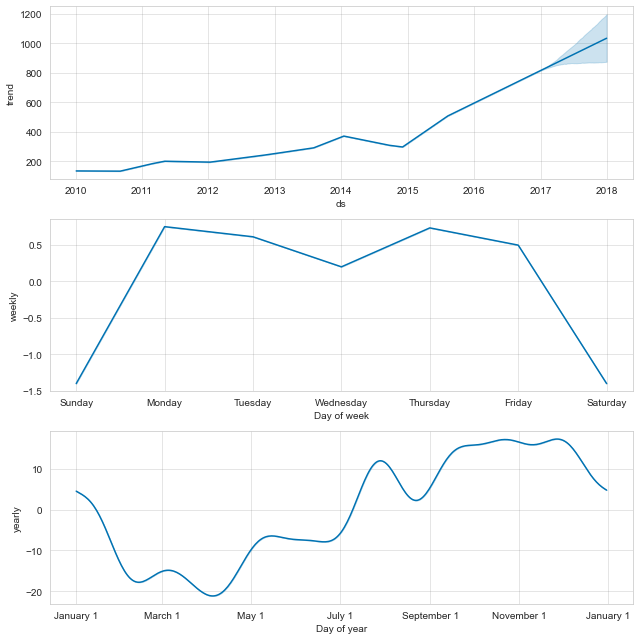

In [512]:
prophet('AMZN',365)

# Include now a second model with public holidays

In [516]:
def prophet_holidays(company, periods, holidays):
    company_stock = new_df[new_df['symbol']==company]['close']
    close_comp=pd.DataFrame()
    # change the headers to ds and y for prophet
    close_comp['ds'] = company_stock.index
    close_comp['y'] = company_stock.values
    
    # prophet analysis
    model = Prophet(yearly_seasonality=True, holidays=holidays)
    model.fit(close_comp)
    
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    figure   = model.plot(forecast, xlabel='Date', ylabel='close')
    figure2  = model.plot_components(forecast)
    return figure , figure2

#### List with us_holidays

In [517]:

ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2010-01-01','2011-01-01','2012-01-01','2013-01-01',
                                                                       '2014-01-01','2015-01-01','2016-01-01'])})

mlk = pd.DataFrame({'holiday': 'Birthday of Martin Luther King, Jr.', 'ds' : pd.to_datetime(['2010-01-18','2011-01-17','2012-01-16','2013-01-21',
                                                                                             '2014-01-20','2015-01-19','2016-01-18'])}) 

wash = pd.DataFrame({'holiday': "Washington's Birthday", 'ds' : pd.to_datetime(['2010-02-15', '2011-02-21','2012-02-20','2013-02-18',
                                                                               '2014-02-17','2015-02-16','2016-02-15'])})

mem = pd.DataFrame({'holiday': 'Memorial Day', 'ds' : pd.to_datetime(['2010-05-31', '2011-05-30','2012-05-28','2013-05-27',
                                                                     '2014-05-26','2015-05-25','2016-05-30'])})

ind = pd.DataFrame({'holiday': 'Independence Day', 'ds' : pd.to_datetime(['2010-07-04', '2011-07-04', '2012-07-04',
                                                                         '2013-07-04','2014-07-04','2015-07-04','2016-07-04'])})

lab = pd.DataFrame({'holiday': 'Labor Day', 'ds' : pd.to_datetime(['2010-09-06','2011-09-05','2012-09-03',
                                                                   '2013-09-02','2014-09-01','2015-09-07','2016-09-05'])})

col = pd.DataFrame({'holiday': 'Columbus Day', 'ds' : pd.to_datetime(['2010-10-11','2011-10-10','2012-10-08','2013-10-11',
                                                                      '2014-10-13', '2015-10-12', '2016-10-10'])})

vet = pd.DataFrame({'holiday': "Veteran's Day", 'ds' : pd.to_datetime(['2010-11-11','2011-11-11','2012-11-11',
                                                                       '2013-11-11', '2014-11-11', '2015-11-11','2016-11-11'])})

thanks = pd.DataFrame({'holiday': 'Thanksgiving Day', 'ds' : pd.to_datetime(['2010-11-25','2011-11-24','2012-11-22','2013-11-28',
                                                                             '2014-11-27','2015-11-26', '2016-11-24'])})

christ = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2010-12-25','2011-12-25','2012-12-25',
                                                                      '2013-12-25','2014-12-25','2015-12-25', '2016-12-25'])})

inaug = pd.DataFrame({'holiday': 'Inauguration Day', 'ds' : pd.to_datetime(['2013-01-20'])})

us_public_holidays = pd.concat([ny, mlk, wash, mem, ind, lab, col, vet, thanks, christ, inaug])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(<Figure size 720x432 with 1 Axes>, <Figure size 648x864 with 4 Axes>)

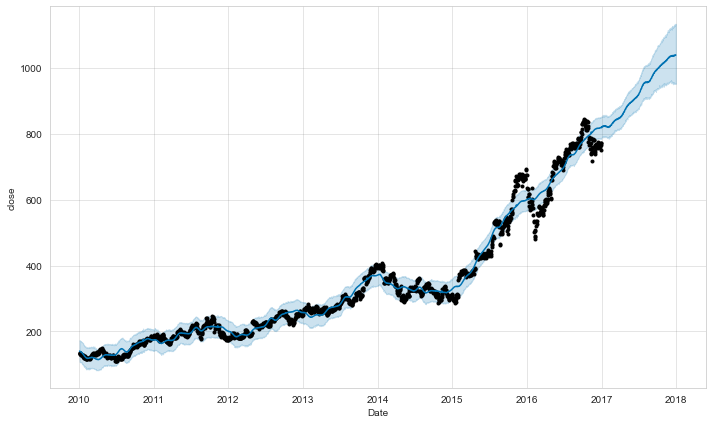

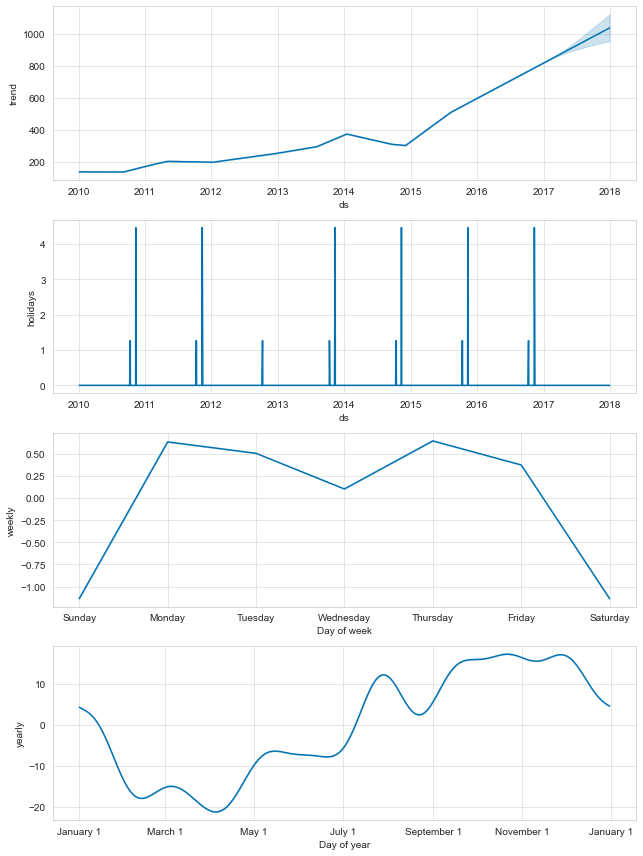

In [518]:
prophet_holidays('AMZN',365,us_public_holidays)

##### Checking on the yahoo finance website [check here](https://finance.yahoo.com/quote/AMZN/history?period1=1478044800&period2=1514851200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true), the predicted values of this model does not seem to be too off the real value

# 2. RNN Models - LSTM model

#### Example for Amazon company

In [236]:
df = close_amzn.set_index('ds')

F:\Ana3\envs\tensorflow_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='ds'>

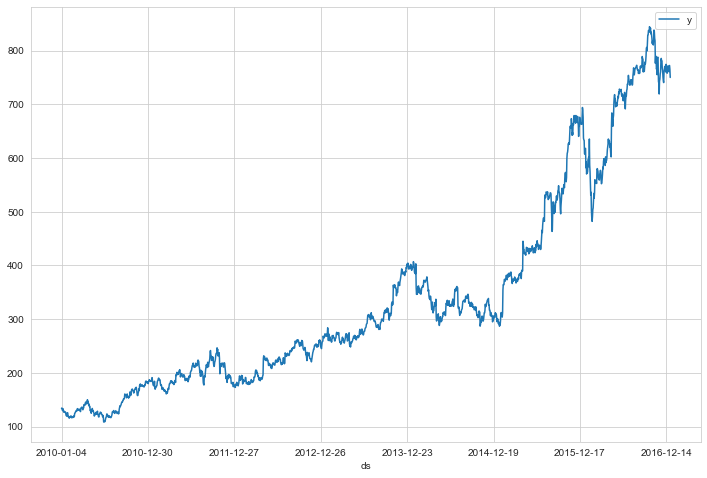

In [237]:
df.plot(figsize=(12,8))

#### Split train and Test

In [238]:
df.shape

(1762, 1)

In [242]:
train = df[:'2016'].values
test = df['2016':].values

In [244]:
train.shape

(1510, 1)

In [245]:
test.shape

(252, 1)

#### Normalize the data

In [248]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train.reshape(-1,1))
scaled_test = scaler.transform(test.reshape(-1,1))

In [255]:
scaled_train.shape

(1510, 1)

In [253]:
scaled_train

array([[0.04320417],
       [0.04455378],
       [0.0403854 ],
       ...,
       [1.        ],
       [0.99162914],
       [0.9691131 ]])

In [256]:
X_train = []
y_train = []
for i in range(30,scaled_train.shape[0]): # 30 stands for the sequence
    X_train.append(scaled_train[i-30:i,0])
    y_train.append(scaled_train[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [350]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(1480, 30, 1)

#### LSTM model

In [496]:
# define model
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.3))

model.add(Dense(50,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

model.compile(optimizer='adam', loss='mse')

In [497]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 30, 50)            10400     
_________________________________________________________________
dropout_42 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 30, 50)            20200     
_________________________________________________________________
dropout_43 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 30, 50)            20200     
_________________________________________________________________
dropout_44 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 50)              

In [498]:
model.fit(X_train,y_train,epochs=50,batch_size=40, validation_split=0.05, verbose=1)

Train on 1406 samples, validate on 74 samples
Epoch 1/50
1406/1406 [==============================] - 15s 11ms/sample - loss: 0.0305 - val_loss: 0.1252
Epoch 2/50
1406/1406 [==============================] - 4s 3ms/sample - loss: 0.0027 - val_loss: 0.0491
Epoch 3/50
1406/1406 [==============================] - 4s 3ms/sample - loss: 0.0023 - val_loss: 0.0175
Epoch 4/50
1406/1406 [==============================] - 4s 3ms/sample - loss: 0.0020 - val_loss: 0.0233
Epoch 5/50
1406/1406 [==============================] - 4s 3ms/sample - loss: 0.0020 - val_loss: 0.0277
Epoch 6/50
1406/1406 [==============================] - 4s 3ms/sample - loss: 0.0019 - val_loss: 0.0143
Epoch 7/50
1406/1406 [==============================] - 4s 3ms/sample - loss: 0.0017 - val_loss: 0.0147
Epoch 8/50
1406/1406 [==============================] - 4s 3ms/sample - loss: 0.0017 - val_loss: 0.0048
Epoch 9/50
1406/1406 [==============================] - 4s 3ms/sample - loss: 0.0016 - val_loss: 0.0172
Epoch 10/50
1406

In [499]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

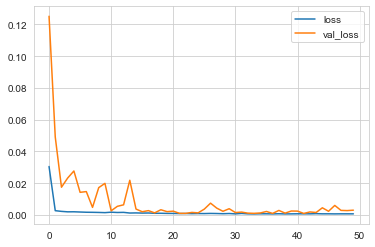

In [500]:
losses.plot()

##### Evaluate on Test Data

In [501]:
dataset_total = pd.concat((df["y"][:'2016'],df["y"]['2016':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test)-30 :].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [502]:
inputs.shape

(282, 1)

In [503]:
X_test = []
y_test = []
for i in range(30,inputs.shape[0]):
    X_test.append(inputs[i-30:i,0])
    y_test.append(inputs[i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)

# Inverse transform is to denormalize the predicted_stock_price
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [504]:
predicted_stock_price

array([[662.8714 ],
       [663.3947 ],
       [658.794  ],
       [649.8046 ],
       [637.0772 ],
       [622.3766 ],
       [608.62695],
       [598.1182 ],
       [590.0007 ],
       [584.1376 ],
       [579.188  ],
       [574.76794],
       [570.9388 ],
       [568.131  ],
       [567.87445],
       [570.6794 ],
       [576.26184],
       [582.3872 ],
       [590.22675],
       [597.1143 ],
       [600.2765 ],
       [597.4184 ],
       [587.6665 ],
       [572.9217 ],
       [554.4603 ],
       [533.8576 ],
       [513.1238 ],
       [494.90524],
       [481.88083],
       [475.49374],
       [476.32886],
       [483.97452],
       [496.10425],
       [510.13757],
       [524.86835],
       [538.6579 ],
       [549.98236],
       [557.85345],
       [561.92267],
       [562.4482 ],
       [561.5278 ],
       [560.8842 ],
       [561.0503 ],
       [561.7649 ],
       [561.8897 ],
       [560.5906 ],
       [557.8215 ],
       [554.0521 ],
       [550.7514 ],
       [548.9158 ],


In [505]:
full_data_withPred = np.concatenate((train,predicted_stock_price),axis=0)

In [507]:
full_data_withTest = np.concatenate((train,test),axis=0)

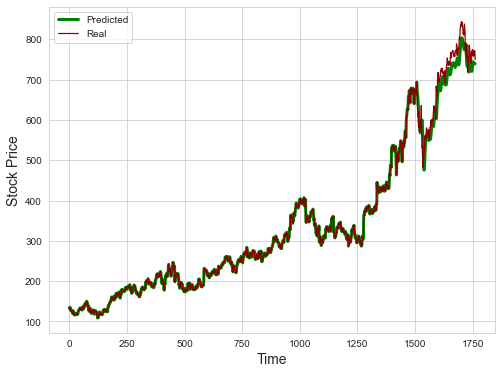

In [508]:
plt.figure(figsize=(8,6))
plt.plot(full_data_withPred, linewidth=3.0, color='green', label='Predicted')
plt.plot(full_data_withTest, linewidth=1.2, color='darkred', label='Real')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)
plt.legend()
plt.show()

#### Evaluate metrics

In [509]:
rmse = math.sqrt(mean_squared_error(test, predicted_stock_price))
rmse

32.098138548617214

In [510]:
r2_score(test, predicted_stock_price)

0.8787457642941993